In [156]:
#standard libraries for data Manipulations
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns

#train/test splits and feature selection (Chi & mutual_info_classif)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

#tweaking the parameters library and repeated dataset split for testing the ML algrorithms
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

#metrics
from sklearn.metrics import classification_report, plot_roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score

#scaling the dataset to mean=0; To get more normally distributed data
# from sklearn.preprocessing import StandardScaler 

# I've decided to use tree-based algorithms. So no need of scaling the data

#ML algorithms that work good with imbalanced datasets (Used one from boosting & one from tree-based)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# encoding and saving the models
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# ---------------------------------------------------------------------------------------------------------
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', '{:.2f}'.format)

In [157]:
credit_tn_org = pd.read_csv(r'credit_train.csv')
credit_test_org = pd.read_csv(r'credit_test.csv')
additional_org = pd.read_csv(r'additional_credit_train_wo_target.csv')

In [158]:
print('Shape credit_tn_org df:',credit_tn_org.shape)
print('Shape credit_test_org df:',credit_test_org.shape)
print('Shape additional_org df:',additional_org.shape,'\n')

print('Missing column:',*(set(credit_tn_org.columns) - set(credit_test_org.columns)))

Shape credit_tn_org df: (136596, 15)
Shape credit_test_org df: (34150, 14)
Shape additional_org df: (91940, 14) 

Missing column: open_account_flg


In [159]:
y = credit_tn_org['open_account_flg']

credit_tn = credit_tn_org.drop(['open_account_flg'],axis=1).copy()
credit_tt = credit_test_org.copy()
additional = additional_org.copy()

In [160]:
print('credit_tn:',credit_tn.shape)
print('credit_tt:',credit_tt.shape)

credit_tn: (136596, 14)
credit_tt: (34150, 14)


In [161]:
credit_tn['test']=False
credit_tt['test']=True
credit_all = credit_tn.append(credit_tt)

In [162]:
credit_all.shape

(170746, 15)

In [163]:
credit_all.head(3)

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,test
0,52372,M,38,MAR,SPC,"12168,00",10,1.10,"0,308454",GRD,ОБЛ ВОЛОГОДСКАЯ,25000.00,0.00,0.00,False
1,75213,F,36,MAR,SPC,"17738,00",10,1.10,"0,498147",GRD,ОБЛ БЕЛГОРОДСКАЯ,25000.00,4.00,0.00,False
2,119931,M,23,UNM,SPC,"26489,00",10,1.10,"0,431980",SCH,ЧЕЛЯБИНСКАЯ ОБЛ,25000.00,NaN,NaN,False


In [164]:
indx_dropped = []

In my opinion, __tariff_id & score_shk are nominal features.__

------

### Functions: Missing values, Distribution plot, boxplot

In [165]:
def missing_v_c(df):
    missing_df = pd.DataFrame(index=credit_tn.columns,columns=['missing in %', 'missing in count'])

    missing_values_prcnt = (df.isnull().sum()/df.shape[0])*100
    missing_values_cnt = df.isnull().sum()
    
    missing_df['missing in %'] = missing_values_prcnt
    missing_df['missing in count'] = missing_values_cnt
    
    return missing_df.loc[missing_df['missing in count'] != 0]

In [166]:
def dist_plots(df, id_, target_column):
    for i in df.columns:
        if (i != id_) & (i != target_column) & (pd.api.types.is_numeric_dtype(df[i])):
            print(i,'\n')
            sns.distplot(df[i])
            plt.show();

In [167]:
def boxplot(df, id_, target_column):
    for i in df.columns:
        if (i != id_) & (i != target_column) & (pd.api.types.is_numeric_dtype(df[i])):
            print(i,'\n')
            sns.boxplot(x=target_column,y=i,data=df)
            plt.show();

In [168]:
def change_living(x):
    if x == '98':
        return u'САНКТПЕТЕРБУРГ'
    if x == '74':
        return u'ЧЕЛЯБИНСК'
    x = x.upper()
    x = x.replace(u'РЕСПУБЛИКА САХА',u'ЯКУТИЯ')
    x = x.replace(u' АВТОНОМНЫЙ ОКРУГ - ЮГРА', u'')
    x = x.replace(u' АВТОНОМНЫЙ ОКРУГ - Ю','')
    x = x.replace(u'ОБЛАСТЬ',u'')
    x = x.replace(u'РЕСПУБЛИКА',u'')
    x = x.replace(u'КРАЙ',u'')
    
    x = x.replace(u'ОБЛ',u'')
    x = x.replace(u'РЕСП',u'')
    x = x.replace(u'Г ',u'')
    x = x.replace(u' Г',u'')
    x = x.replace(u'Г. ',u'')
    x = x.replace(u'Г.',u'')
    x = x.replace(u'АО',u'')
    x = x.replace(u'АО ',u'')
    x = x.replace(u' АО',u'')
    

    x = x.replace(u'ГМОСКВА','МОСКВА')
    x = x.replace(u'Р-Н',u'')
    x = x.replace(u'САХА','')
    
    x = x.replace(u'-','')
    x = x.replace(u')','')
    x = x.replace(u'(','')
    x = x.replace(u'/','')
    x = x.replace(u'.','')
    x = x.replace(u' ',u'')
    
    return x

------

# EDA

### Checking for the class distribution (open_account_flg)

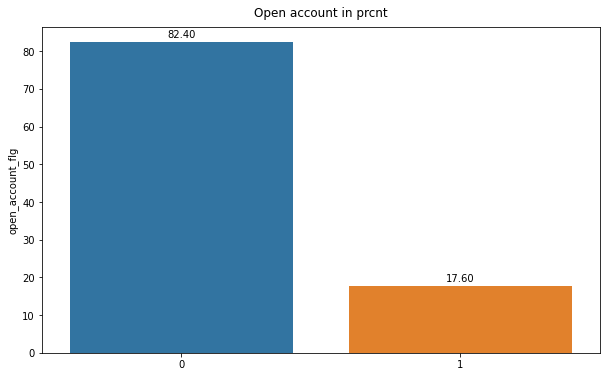

In [169]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=credit_tn_org.open_account_flg.value_counts().index,y=credit_tn_org.open_account_flg.value_counts(normalize=True)*100)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)
ax.set_title('Open account in prcnt',pad=10);

# We are dealing with imbalanced dataset. Common ways of solving:
# 1. Sampling methods (Oversampling, undersampling...)
# 2. Tree-based algorithms can handle imbalanced datasets
# 3. Boosting algorithms can handle imbalanced datasets. 
#    They give  higher weight to the minority class at each successive iteration

### Checking for the patterns

#### score_shk & open_account_flg

In [170]:
# ['open_account_flg']==1
print(f'''MIN: {credit_tn_org.loc[credit_tn_org['open_account_flg']==1]['score_shk'].min()}
MAX: {credit_tn_org.loc[credit_tn_org['open_account_flg']==1]['score_shk'].max()}''')

MIN: 0,072468
MAX: 1,054699


In [171]:
# ['open_account_flg']==0
print(f'''MIN: {credit_tn_org.loc[credit_tn_org['open_account_flg']==0]['score_shk'].min()}
MAX: {credit_tn_org.loc[credit_tn_org['open_account_flg']==0]['score_shk'].max()}''')

MIN: 0,000000
MAX: 1,128291


#### overdue_credit_count & open_account_flg

In [172]:
credit_tn_org.overdue_credit_count.value_counts()

0.00    123281
1.00      5909
2.00        38
3.00         3
Name: overdue_credit_count, dtype: int64

In [173]:
print(f'''MIN: {credit_tn_org.loc[credit_tn_org['open_account_flg']==1]['overdue_credit_count'].min()}
MAX: {credit_tn_org.loc[credit_tn_org['open_account_flg']==1]['overdue_credit_count'].max()}''')

MIN: 0.0
MAX: 2.0


In [174]:
credit_tn_org.loc[credit_tn_org['open_account_flg']==1]['overdue_credit_count'].value_counts()

0.00    20078
1.00     1199
2.00       11
Name: overdue_credit_count, dtype: int64

In [175]:
print(f'''MIN: {credit_tn_org.loc[credit_tn_org['open_account_flg']==0]['overdue_credit_count'].min()}
MAX: {credit_tn_org.loc[credit_tn_org['open_account_flg']==0]['overdue_credit_count'].max()}''')

MIN: 0.0
MAX: 3.0


In [176]:
credit_tn_org.loc[credit_tn_org['open_account_flg']==0]['overdue_credit_count'].value_counts()

0.00    103203
1.00      4710
2.00        27
3.00         3
Name: overdue_credit_count, dtype: int64

#### credit_count & open_account_flg

In [177]:
credit_tn_org.groupby(['credit_count','open_account_flg']).count()['client_id'].to_frame()

client_id
credit_count open_account_flg           
0.00         0                     17751
             1                      2969
1.00         0                     30196
             1                      5974
2.00         0                     24845
             1                      4693
3.00         0                     15916
             1                      3282
4.00         0                      9362
             1                      1967
5.00         0                      4898
             1                      1097
6.00         0                      2497
             1                       613
7.00         0                      1282
             1                       322
8.00         0                       606
             1                       183
9.00         0                       300
             1                        84
10.00        0                       122
             1                        47
11.00        0                        77
             1                        20
12.00        0                        46
             1                        18
13.00        0                        23
             1                         5
14.00        0                         9
             1                         3
15.00        0                         6
             1                         4
16.00        0                         1
             1                         2
17.00        0                         3
             1                         2
18.00        0                         1
             1                         1
19.00        0                         2
             1                         1
21.00        1                         1

#### job_position & open_account_flg

In [178]:
jb = credit_tn_org.groupby(['job_position','open_account_flg']).count()['client_id'].reset_index()

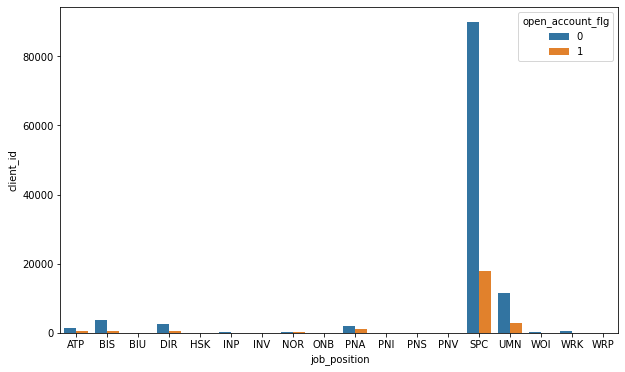

In [179]:
fig,ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x='job_position',y='client_id',hue='open_account_flg',data=jb)

#### tariff_id & open_account_flg

In [180]:
credit_tn_org.groupby(['tariff_id','open_account_flg']).count()['client_id'].to_frame()

client_id
tariff_id open_account_flg           
1.00      0                      1684
          1                       121
1.10      0                     44937
          1                     10537
1.16      0                      2275
          1                       268
1.17      0                       488
          1                       102
1.18      0                         2
          1                        24
1.19      0                      1502
          1                       191
1.20      0                       950
          1                       103
1.21      0                       441
          1                        16
1.22      0                       282
          1                        10
1.23      0                       269
          1                        13
1.24      0                       205
          1                        40
1.25      0                        34
          1                        10
1.26      0                         5
          1                         1
1.27      0                         5
1.28      0                         9
1.29      1                         1
1.30      0                      1863
          1                       792
1.32      0                      7700
          1                      4760
1.40      0                      7761
          1                       981
1.41      0                        87
          1                        23
1.43      0                      2780
          1                       379
1.44      0                      1560
          1                       220
1.48      0                         5
1.50      0                      5429
          1                       585
1.52      0                         4
1.56      0                         2
1.60      0                     26887
          1                      4389
1.70      0                       744
          1                        87
1.90      0                      4167
          1                       296
1.91      0                       193
          1                        63
1.94      0                       281
          1                        33

#### Gender & open_account_flg

In [181]:
credit_tn_org.groupby(['gender','open_account_flg']).count()['client_id'].to_frame()

client_id
gender open_account_flg           
F      0                     59589
       1                     11366
M      0                     52962
       1                     12679

In [182]:
credit_tn_org.loc[credit_tn_org['open_account_flg']==1]['gender'].value_counts(normalize=True)

M   0.53
F   0.47
Name: gender, dtype: float64

In [183]:
credit_tn_org.loc[credit_tn_org['open_account_flg']==0]['gender'].value_counts(normalize=True)

F   0.53
M   0.47
Name: gender, dtype: float64

#### living_region - clients most accepted and rejected usage of credit

In [184]:
credit_tn_org['living_region'].fillna('НЕИЗВЕСТНО', inplace=True)
credit_tn_org['living_region_cleaned'] = credit_tn_org['living_region'].apply(change_living)

In [185]:
# accepted
credit_tn_org.loc[credit_tn_org['open_account_flg']==1].groupby('living_region_cleaned').count()['client_id'].nlargest(10)

living_region_cleaned
МОСКОВСКАЯ        1811
МОСКВА            1530
КРАСНОДАРСКИЙ     1317
САНКТПЕТЕРБУРГ     974
СВЕРДЛОВСКАЯ       964
ТАТАРСТАН          898
ЧЕЛЯБИНСКАЯ        786
БАШКОРТОСТАН       743
ИРКУТСКАЯ          741
РОСТОВСКАЯ         686
Name: client_id, dtype: int64

In [186]:
# rejected
credit_tn_org.loc[credit_tn_org['open_account_flg']==0].groupby('living_region_cleaned').count()['client_id'].nlargest(10)

living_region_cleaned
МОСКОВСКАЯ        8485
МОСКВА            5849
САНКТПЕТЕРБУРГ    5701
КРАСНОДАРСКИЙ     5313
ТАТАРСТАН         5216
СВЕРДЛОВСКАЯ      4933
БАШКОРТОСТАН      4437
САМАРСКАЯ         3574
ЧЕЛЯБИНСКАЯ       3369
СТАВРОПОЛЬСКИЙ    3327
Name: client_id, dtype: int64

### Checking for missing values

In [187]:
credit_all.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,test
0,52372,M,38,MAR,SPC,"12168,00",10,1.10,"0,308454",GRD,ОБЛ ВОЛОГОДСКАЯ,25000.00,0.00,0.00,False
1,75213,F,36,MAR,SPC,"17738,00",10,1.10,"0,498147",GRD,ОБЛ БЕЛГОРОДСКАЯ,25000.00,4.00,0.00,False
2,119931,M,23,UNM,SPC,"26489,00",10,1.10,"0,431980",SCH,ЧЕЛЯБИНСКАЯ ОБЛ,25000.00,NaN,NaN,False
3,134365,M,24,UNM,SPC,"20379,00",12,1.60,"0,770546",GRD,РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ,50000.00,NaN,NaN,False
4,138695,F,47,MAR,SPC,"12019,00",10,1.60,"0,617275",SCH,УЛЬЯНОВСКАЯ ОБЛ,18000.00,0.00,0.00,False


In [188]:
missing_v_c(credit_all)

,missing in %,missing in count
living_region,0.11,192
monthly_income,0.00,1
credit_count,5.41,9230
overdue_credit_count,5.41,9230


### Cat. features 

In [189]:
credit_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 0 to 34149
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170746 non-null  int64  
 3   marital_status        170746 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170746 non-null  object 
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  float64
 8   score_shk             170746 non-null  object 
 9   education             170746 non-null  object 
 10  living_region         170554 non-null  object 
 11  monthly_income        170745 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  test                  170746 non-null  bool   
dtypes

In [190]:
# changing the comma separation to dot separation 
for i in credit_all.columns:
    if pd.api.types.is_object_dtype(credit_all[i]):
        try:
            credit_all[i]=credit_all[i].str.replace(',','.').astype('float')
        except:
            pass

In [191]:
# We can delete 154 missing values from column "living_region". But I've decided to keep them
# credit_tn.dropna(subset=['living_region'],inplace=True)

print(f'''Filled {credit_all['living_region'].isnull().sum()} missing values with "Unknown"''')
credit_all['living_region'].fillna('НЕИЗВЕСТНО', inplace=True)

Filled 192 missing values with "Unknown"


In [192]:
# Cleaning the "living_region" column
credit_all['living_region'].unique()

array(['ОБЛ ВОЛОГОДСКАЯ', 'ОБЛ БЕЛГОРОДСКАЯ', 'ЧЕЛЯБИНСКАЯ ОБЛ',
       'РЕСП КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'УЛЬЯНОВСКАЯ ОБЛ',
       'КРАЙ СТАВРОПОЛЬСКИЙ', 'САНКТ-ПЕТЕРБУРГ Г', 'ОМСКАЯ ОБЛ',
       'ОБЛ КАЛУЖСКАЯ', 'ОБЛ ТВЕРСКАЯ', 'РЕСП БАШКОРТОСТАН',
       'ОБЛ НИЖЕГОРОДСКАЯ', 'ТЫВА РЕСП', 'СВЕРДЛОВСКАЯ ОБЛ',
       'САХА /ЯКУТИЯ/ РЕСП', 'КРАЙ КАМЧАТСКИЙ', 'РЕСП КАРЕЛИЯ',
       'ТАМБОВСКАЯ ОБЛ', 'РЕСПУБЛИКА ТАТАРСТАН', 'Г. САНКТ-ПЕТЕРБУРГ',
       'ЛЕНИНГРАДСКАЯ ОБЛАСТЬ', 'ТВЕРСКАЯ ОБЛ', 'РОСТОВСКАЯ ОБЛ',
       'ПЕРМСКИЙ КРАЙ', 'ТАТАРСТАН РЕСП', 'МОСКВА', 'РЕСП. БАШКОРТОСТАН',
       'ПСКОВСКАЯ ОБЛАСТЬ', 'ОБЛ ВОРОНЕЖСКАЯ', 'КРАСНОДАРСКИЙ КРАЙ',
       'САНКТ-ПЕТЕРБУРГ', 'ОБЛ МУРМАНСКАЯ', 'МОСКВА Г', 'ХАКАСИЯ РЕСП',
       'КРАСНОЯРСКИЙ КРАЙ', 'ОБЛ КУРСКАЯ', 'КРАЙ ПЕРМСКИЙ',
       'ХАБАРОВСКИЙ КРАЙ', 'САМАРСКАЯ ОБЛАСТЬ', 'ОБЛ ЛИПЕЦКАЯ',
       'ЧУВАШСКАЯ РЕСПУБЛИКА', 'ОБЛ МОСКОВСКАЯ', 'ОРЛОВСКАЯ ОБЛ',
       'САХАЛИНСКАЯ ОБЛ', 'ОБЛ КЕМЕРОВСКАЯ', 'ЯМАЛО-НЕНЕЦКИЙ АО',
       'ОБЛ АСТРАХАНС

ОБЛ <br>
РЕСП <br>
Г<br>
САХА<br>
Г. <br>
ОБЛАСТЬ<br>
РЕСП. <br>
РЕСПУБЛИКА<br>
АО<br>
КРАЙ<br>
'САХА(ЯКУТИЯ)'<br>
РЕСПУБЛИКА САХА:<br>
https://www.google.com/search?q=%D0%A0%D0%95%D0%A1%D0%9F%D0%A3%D0%91%D0%9B%D0%98%D0%9A%D0%90+%D0%A1%D0%90%D0%A5%D0%90&oq=%D0%A0%D0%95%D0%A1%D0%9F%D0%A3%D0%91%D0%9B%D0%98%D0%9A%D0%90+%D0%A1%D0%90%D0%A5%D0%90&aqs=chrome..69i57.238j0j7&sourceid=chrome&ie=UTF-8<br>
98 - Санкт-Петербург<br>
74 - Челябинск

In [193]:
credit_all['living_region_cleaned'] = credit_all['living_region'].apply(change_living)    

In [194]:
credit_all['living_region_cleaned'].unique()

array(['ВОЛОГОДСКАЯ', 'БЕЛГОРОДСКАЯ', 'ЧЕЛЯБИНСКАЯ',
       'КАРАЧАЕВОЧЕРКЕССКАЯ', 'УЛЬЯНОВСКАЯ', 'СТАВРОПОЛЬСКИЙ',
       'САНКТПЕТЕРБУРГ', 'ОМСКАЯ', 'КАЛУЖСКАЯ', 'ТВЕРСКАЯ',
       'БАШКОРТОСТАН', 'НИЖЕГОРОДСКАЯ', 'ТЫВА', 'СВЕРДЛОВСКАЯ', 'ЯКУТИЯ',
       'КАМЧАТСКИЙ', 'КАРЕЛИЯ', 'ТАМБОВСКАЯ', 'ТАТАРСТАН',
       'ЛЕНИНГРАДСКАЯ', 'РОСТОВСКАЯ', 'ПЕРМСКИЙ', 'МОСКВА', 'ПСКОВСКАЯ',
       'ВОРОНЕЖСКАЯ', 'КРАСНОДАРСКИЙ', 'МУРМАНСКАЯ', 'ХАКАСИЯ',
       'КРАСНОЯРСКИЙ', 'КУРСКАЯ', 'ХАБАРОВСКИЙ', 'САМАРСКАЯ', 'ЛИПЕЦКАЯ',
       'ЧУВАШСКАЯ', 'МОСКОВСКАЯ', 'ОРЛОВСКАЯ', 'ЛИНСКАЯ', 'КЕМЕРОВСКАЯ',
       'ЯМАЛОНЕНЕЦКИЙ', 'АСТРАХАНСКАЯ', 'СЕВОСЕТИЯАЛАНИЯ', 'ВЛАДИМИРСКАЯ',
       'ХАНТЫМАНСИЙСКИЙ', 'КОМИ', 'НОВОСИБИРСКАЯ', 'КАЛИНИНГРАДСКАЯ',
       'МОРДОВИЯ', 'БУРЯТИЯ', 'ИРКУТСКАЯ', 'УДМУРТСКАЯ', 'ЕВРЕЙСКАЯА',
       'КАБАРДИНОБАЛКАРСКАЯ', 'МАРИЙЭЛ', 'ПЕНЗЕНСКАЯ', 'АМУРСКАЯ',
       'ВОЛГОГРАДСКАЯ', 'АДЫГЕЯ', 'ЯРОСЛАВСКАЯ', 'ТЮМЕНСКАЯ',
       'ОРЕНБУРГСКАЯ', 'КУРГАНСКАЯ', 'САРАТОВСКАЯ', 'ИВАНОВСКА

In [195]:
# There is only one missing value in "monthly_income", used the median of the whole column
# If there would be more missing values, to get more precise result I'd use:
#                     df.groupby(['age','living_region','job_position']).transform(lambda x: x.fillna(x.median()))

credit_all.monthly_income.fillna(credit_all.monthly_income.median(), inplace=True)

In [196]:
missing_v_c(credit_all)

,missing in %,missing in count
credit_count,5.41,9230
overdue_credit_count,5.41,9230


In [197]:
# The clients with NULL values in "credit_count" have NULL values in "overdue_credit_count" as well
# Can't see any feature to extract useful data to fill the columns with missing values. Drop them!

# credit_tn.loc[(credit_tn['credit_count'].isnull() == True) & (credit_tn['overdue_credit_count'].isnull() == True)]
credit_all.loc[(credit_all['credit_count'].isnull() == True) & (credit_all['overdue_credit_count'].isnull() == True)].shape[0]

9230

In [198]:
[indx_dropped.append(i) for i in credit_all.loc[(credit_all['credit_count'].isnull()==True)&(credit_all['test']==False)].index]
credit_all.dropna(subset=['credit_count'],inplace=True)

In [199]:
credit_all.isnull().sum().sum()

0

In [200]:
# we have skewed data
credit_all.describe()

,client_id,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count
count,161516.00,161516.00,161516.00,161516.00,161516.00,161516.00,161516.00,161516.00,161516.00
mean,85362.21,37.04,25934.36,10.99,1.32,0.46,40416.55,2.11,0.05
std,49278.53,10.40,16193.70,3.54,0.24,0.12,25324.45,1.78,0.21
min,1.00,18.00,2736.00,3.00,1.00,0.00,5000.00,0.00,0.00
25%,42681.75,29.00,14828.00,10.00,1.10,0.38,25000.00,1.00,0.00
50%,85367.50,35.00,21076.67,10.00,1.32,0.46,35000.00,2.00,0.00
75%,128054.25,43.00,31768.00,12.00,1.60,0.55,50000.00,3.00,0.00
max,170746.00,71.00,200000.00,36.00,1.96,0.98,950000.00,21.00,3.00


# Outliers detection

In [201]:
boxplot_df = credit_all.loc[credit_all.test == False].copy()
boxplot_df['open_account_flg'] = y

age 



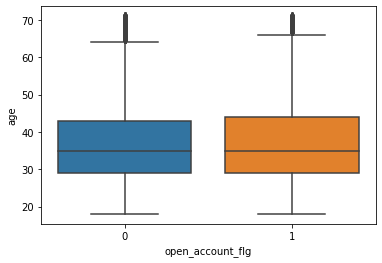

credit_sum 



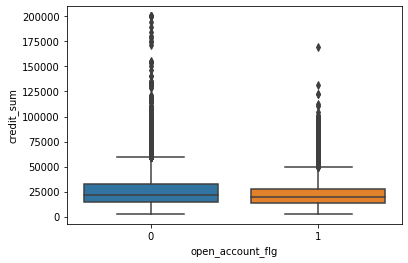

credit_month 



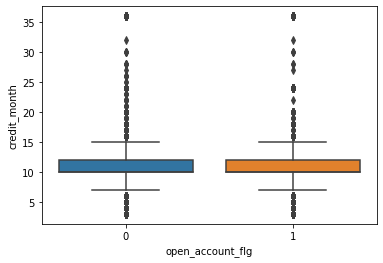

tariff_id 



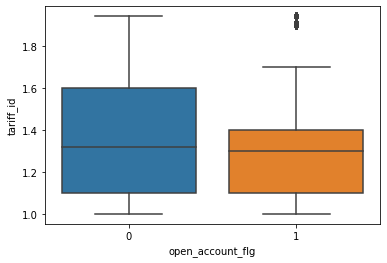

score_shk 



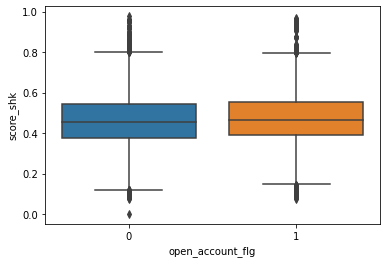

monthly_income 



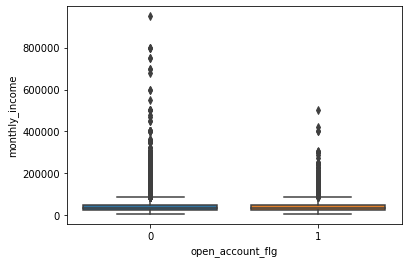

credit_count 



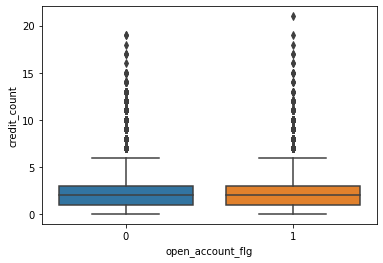

overdue_credit_count 



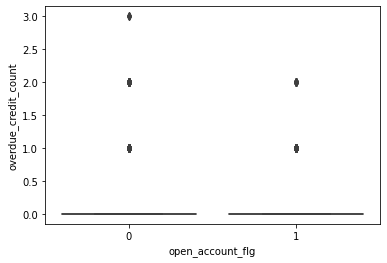

test 



TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

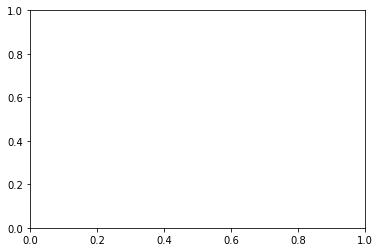

In [202]:
boxplot(boxplot_df,'client_id','open_account_flg')

In [ ]:
# checking for distribution
dist_plots(boxplot_df, 'client_id','open_account_flg')

In [ ]:
columns_skewed= ['credit_sum', 'credit_month', 'monthly_income']

In [203]:
# skewness
for i in columns_skewed:
# ---- Quantile method

# Decided not to delete the outliers. But we can achieve it by using quantile method

#     q = credit_all[i].quantile(0.99)
#     test_df = credit_all[credit_all[i]<q]
#     test_df.describe(include='all')['credit_sum']

# ---- log method
    credit_all[i]=np.log(credit_all[i])

<AxesSubplot:xlabel='credit_sum', ylabel='Density'>

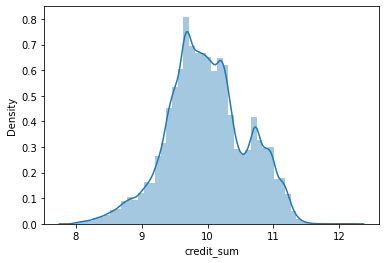

In [204]:
sns.distplot(credit_all['credit_sum'])

------

### Due to usage of OneHotEncoder before starting the trainig, I have commented out this part.
OneHotEncoder can be pickled and reused with new unseen data

In [205]:
# Tariff column (Let's consider it as an encoded client tariff plan, which makes the following column categorical)
credit_all.tariff_id.value_counts()

1.10    66319
1.60    35420
1.32    14841
1.40    10619
1.50     7224
1.90     5369
1.43     3657
1.30     3152
1.16     3149
1.00     2182
1.44     2057
1.19     2028
1.20     1274
1.70      976
1.17      701
1.21      556
1.94      408
1.22      363
1.23      354
1.91      312
1.24      297
1.41      125
1.25       55
1.18       36
1.28       10
1.26       10
1.52        7
1.27        6
1.48        5
1.56        2
1.29        1
1.96        1
Name: tariff_id, dtype: int64

In [206]:
most_tariff = credit_all.tariff_id.value_counts().index[:-8]
other_tariff = credit_all.tariff_id.value_counts().index[-8:]

-------

In [207]:
print(f'''
We have lost: {round(((credit_tn_org.shape[0]+credit_test_org.shape[0]) - credit_all.shape[0])/(credit_tn_org.shape[0]+credit_test_org.shape[0])*100,3)}% of our data!
''')


We have lost: 5.406% of our data!



In [208]:
y=y.iloc[list(set(y.index)-set(indx_dropped))]

In [209]:
y.shape[0]==credit_all[credit_all['test']==False].shape[0]

True

### Feature Importance using Chi2 example

Chi2 is best for categorical features. In our case, there is some valuable info

In [247]:
# the following line of code will be used as our X in train/test split
X = credit_all.loc[credit_all['test']==False].copy()

In [59]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [60]:
score_table = pd.DataFrame(columns=['score'])
score_table['score']=fs.scores_
score_table=score_table.reset_index().rename(columns={'index':'featureNumber'})

score_table['score'] = round(score_table.score,2)
# score_table['feature_names'] = X.columns[fs.get_support()]

score_table = score_table.sort_values(by='score',ascending=False,ignore_index=True).fillna(0)

In [61]:
score_table.loc[score_table['score']>50]

,featureNumber,score
0,435,2358.28
1,21,593.32
2,438,240.65
3,434,240.00
4,30,217.38
5,32,197.09
6,114,175.49
7,6,164.27
8,437,163.22
9,440,142.64


### Feature Importance using mutual_info_classif method example

##### In our case, relationship between the variables are weak


In [105]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [106]:
score_table = pd.DataFrame(columns=['score'])
score_table['score']=fs.scores_
score_table=score_table.reset_index().rename(columns={'index':'featureNumber'})

score_table['score'] = round(score_table.score,2)
# score_table['feature_names'] = X.columns[fs.get_support()]

score_table = score_table.sort_values(by='score',ascending=False,ignore_index=True).fillna(0)

In [107]:
fs.scores_

array([1.11369750e-03, 4.50406886e-03, 2.20265569e-02, 1.26291629e-02,
       1.63112086e-03, 3.66406272e-04, 3.79057484e-03, 3.60347829e-04,
       0.00000000e+00, 3.82575301e-03, 5.53457541e-04, 5.34981434e-03,
       1.62596651e-03, 8.20132935e-04, 0.00000000e+00, 0.00000000e+00,
       1.26627563e-03, 0.00000000e+00, 5.90998150e-04, 6.13228742e-04,
       1.88767953e-03, 3.52281892e-03, 0.00000000e+00, 0.00000000e+00,
       6.36521971e-04, 1.06239293e-02, 0.00000000e+00, 0.00000000e+00,
       5.58483329e-05, 0.00000000e+00, 4.91948516e-03, 0.00000000e+00,
       5.47215996e-03, 0.00000000e+00, 2.64238099e-03, 5.04569498e-04,
       2.35229757e-03, 0.00000000e+00, 8.01505272e-04, 0.00000000e+00,
       2.45472309e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.72881024e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.48975734e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.29622378e-03, 0.00000000e+00,
      

## Prediction

In [248]:
# Preparing the data 
X.drop(['living_region','test','client_id'], axis=1,inplace=True)

In [249]:
ct = ColumnTransformer([('one-hot-encoder', OneHotEncoder(drop='first'), ['gender', 'marital_status',
                                                                         'job_position','tariff_id',
                                                                         'education','living_region_cleaned'])], remainder='passthrough')

X=ct.fit_transform(X)

In [251]:
#saving the encoding
joblib.dump(ct, 'encoder.joblib')

['encoder.joblib']

------

# Testing the saved encoding

In [256]:
X_enc = credit_all.loc[credit_all['test']==False].copy()

In [258]:
X_enc.drop(['living_region','test','client_id'], axis=1,inplace=True)

In [259]:
enc = joblib.load('encoder.joblib')
X_enc=enc.fit_transform(X_enc)

----

#### DecisionTreeClassifier

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

tree = DecisionTreeClassifier()

params_tree = {'max_depth' : [5, 10, 15],
               'min_samples_split' : [5, 10, 20, 50]}

tree_model = GridSearchCV(tree, params_tree, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc').fit(X_train, y_train).best_estimator_

print(classification_report(y_test, tree_model.predict(X_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     32383
           1       0.45      0.06      0.11      6387

    accuracy                           0.83     38770
   macro avg       0.65      0.52      0.51     38770
weighted avg       0.78      0.83      0.78     38770



In [252]:
cm = confusion_matrix(y_test,tree_model.predict(X_test))

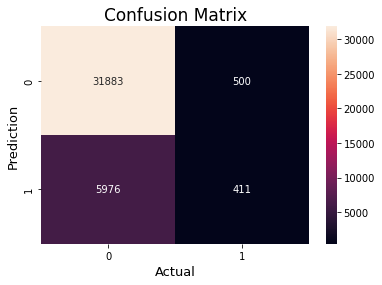

In [253]:
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

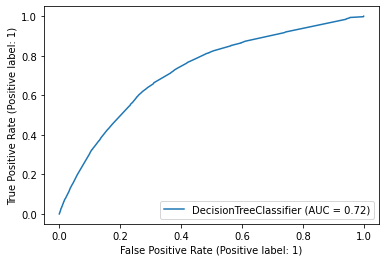

In [254]:
plot_roc_curve(tree_model, X_test, y_test);

In [255]:
scores = cross_val_score(tree_model, X, y, scoring='roc_auc', cv=3, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.72534


#### XGBoost

We have improved our model by the help of:
1. Boosting algorithm
2. GridSearchCV (Unfortunately, it takes a lot of time to train on more parameters)

In [228]:
xgb = XGBClassifier()

params_xgb = {'max_depth' : [3], # [3,5,8,10,12,15]
             'scale_pos_weight': [np.sum(y == 0) / float(np.sum(y == 1))] # [10,20,30,40,50,60,100]}

'''
                    scale_pos_weight --> # of positive samples * sample_pos_weight = # of negative samples
                                        
np.sum(y == 0) / float(np.sum(y == 1)) --> sample_pos_weight = # of negative samples / # of positive samples 

It helps to improve the performance on positive class. So, in my opinion that's the reason our model has improved
for positive classes a bit and increased our mean ROC AUC from 0.726 to 0.758
'''

xgb_model = GridSearchCV(xgb, params_xgb, cv=3, verbose=1, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train).best_estimator_

print(classification_report(y_test, xgb_model.predict(X_test)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/Bonu/opt/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     32383
           1       0.30      0.69      0.42      6387

    accuracy                           0.68     38770
   macro avg       0.61      0.69      0.60     38770
weighted avg       0.82      0.68      0.72     38770



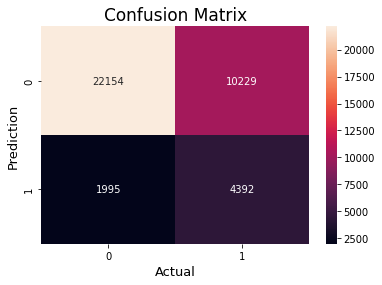

In [229]:
cm = confusion_matrix(y_test,xgb_model.predict(X_test))
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [230]:
scores = cross_val_score(xgb_model, X, y, scoring='roc_auc', cv=3, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.75615


# Saving and testing the model

In [268]:
joblib.dump(xgb_model, 'xgb_model.joblib')

['xgb_model.joblib']

In [269]:
xgb_m = joblib.load('xgb_model.joblib')

In [296]:
xgb_m.predict(X_train[2])

0

------

__Hope you'll help to test the following peace of code for me :) (Due to low performance of my laptop, I had to stop the trainning)__

- The main difference is in "RepeatedStratifiedKFold", which splits the dataset as "StratifiedKFold" does. 
- But it splits (splits in such way that the splitted dataset is balanced) and trains the same dataset several times (in our case it repeats for 3 times on 10 splitted datasets), accordingly it performs better than "StratifiedKFold".


In [71]:
# model
model = XGBClassifier()

#grid
weights = [1, np.sum(y == 0) / float(np.sum(y == 1)),10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

#evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X, y)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 